This cell is for importing necessary modules.

In [65]:
import heapq  # for minimum spanning tree
import itertools
import os
import pickle  # for saving the data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

This cell is for reading the data file and only looking at the prices for different stocks.

In [25]:
PSE_data = pd.read_csv("daily.csv")
PSE_data["date_id"] = pd.to_datetime(PSE_data["date_id"])
PSE_data = PSE_data.set_index("date_id")
df_filtered = PSE_data.drop(
    columns=[
        col
        for col in PSE_data.columns
        if not (col.startswith("PH_") and col.endswith("_P")) and col != "date_id"
    ]
)
df_filtered = df_filtered.loc["2013-06-25":"2023-09-26"]

This code is for removing the other rows that are not within the last 10 years of the data. I also used the date June 25, 2013 as the start date so that:
- the window size will not cut the amount of days
- when I calculate log returns, I will have exactly 10 years worth of data. 

In [26]:
# def has_high_null_percentage(column, null_threshold):
#     return column.isnull().mean() > null_threshold

# # def has_consecutive_constant_values(column, threshold):
# #     constant_streak = column.groupby((column != column.shift()).cumsum()).transform('size')
# #     return constant_streak.max() > threshold

# # def has_end_constant_values(column, end_threshold):
# #     end_section = column.iloc[-int(len(column) * 0.05):]
# #     return end_section.nunique() == 1

# # def has_few_variations(column, variation_threshold):
# #     return column.nunique() < variation_threshold

# null_percentage_threshold = round(df_filtered.shape[0] * 0.85)
# # consecutive_constant_threshold = int(len(df_filtered) * 0.35)
# # end_constant_threshold = 0.01
# # variation_threshold = 50

# columns_to_drop = []

# for col in df_filtered.columns:
#     if col == "date_id":
#         continue

#     if (
#         has_high_null_percentage(df_filtered[col], null_percentage_threshold) # or
#         # has_consecutive_constant_values(df_filtered[col], consecutive_constant_threshold) or
#         # has_end_constant_values(df_filtered[col], end_constant_threshold) or
#         # has_few_variations(df_filtered[col], variation_threshold)
#     ):
#         columns_to_drop.append(col)

# df_filtered = df_filtered.drop(columns=columns_to_drop)

In [27]:
def has_high_null_percentage(column, null_threshold):
    return column.isnull().sum() > null_threshold


null_percentage_threshold = round(df_filtered.shape[0] * 0.80)

columns_to_drop = []
for col in df_filtered.columns:
    if col == "date_id":
        continue
    if has_high_null_percentage(df_filtered[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)

In [28]:
df_filtered.isnull().sum()

PH_ASA_P      0
PH_ABS_P      0
PH_AGN_P      0
PH_APC_P      0
PH_CHP_P    799
           ... 
PH_H2O_P      0
PH_PRC_P      0
PH_SSN_P      0
PH_SIN_P      0
PH_SHK_P    907
Length: 277, dtype: int64

In [46]:
# turn constant values into nans

for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].mask(
        df_filtered[col] == df_filtered[col].shift()
    )

valid_cols = [col for col in df_filtered.columns if df_filtered[col].notna().sum() > 10]
valid_df = df_filtered[valid_cols]  # valid_cols is a dataframe
# df_filtered.loc[df_filtered.index[-1], valid_cols] = valid_df.ffill().iloc[-1] #removed this
df_interpolated = valid_df.interpolate(method="akima")

In [73]:
valid_df.isnull().sum()

PH_ASA_P    2543
PH_ABS_P    2019
PH_AGN_P    2402
PH_APC_P    2629
PH_CHP_P    2577
            ... 
PH_H2O_P    2446
PH_PRC_P    2523
PH_SSN_P    2381
PH_SIN_P    2645
PH_SHK_P    2451
Length: 226, dtype: int64

In [47]:
print(df_interpolated.shape)
print(df_interpolated.isnull().sum())

(2676, 226)
PH_ASA_P      0
PH_ABS_P      0
PH_AGN_P      0
PH_APC_P      0
PH_CHP_P    799
           ... 
PH_H2O_P      0
PH_PRC_P      0
PH_SSN_P      0
PH_SIN_P      0
PH_SHK_P    907
Length: 226, dtype: int64


In [48]:
columns_to_drop = []
for col in df_interpolated.columns:
    if col == "date_id":
        continue
    if has_high_null_percentage(df_interpolated[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_interpolated = df_interpolated.drop(columns=columns_to_drop)

In [50]:
df_interpolated.shape

(2676, 226)

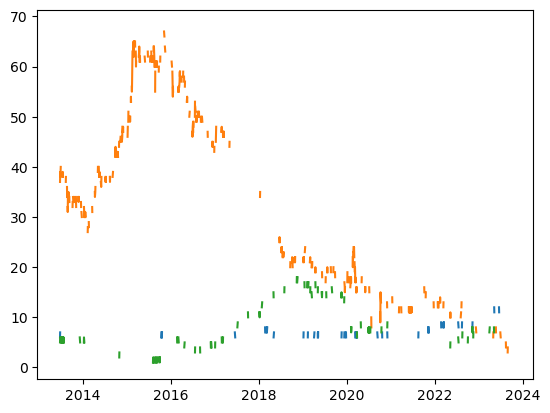

In [55]:
# This is for original data
for col in valid_df.iloc[:, :3]:
    plt.plot(valid_df[col])
plt.show()

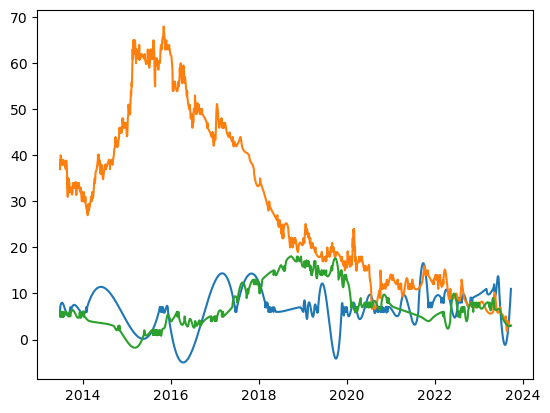

In [54]:
# This is for akima
for col in df_interpolated.iloc[:, :3]:
    plt.plot(df_interpolated[col])
plt.show()

This cell is for calculating log returns.

In [59]:
PSE_log_returns = df_interpolated.copy()
numeric_cols = PSE_log_returns.columns.difference(["date_id"])
PSE_log_returns[numeric_cols] = PSE_log_returns[numeric_cols].replace(0, np.nan)
PSE_log_returns[numeric_cols] = np.log(
    PSE_log_returns[numeric_cols] / PSE_log_returns[numeric_cols].shift(1)
)

/home/bsdsba2027/dfgo/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


I removed the the row for September 25, 2013, and I filled all the nan values with zero.

In [60]:
PSE_log_returns = PSE_log_returns.loc["2013-09-26":"2023-09-26"]
PSE_log_returns.columns = PSE_log_returns.columns.str.replace(r"_P", "").str.replace(
    r"PH_", ""
)

# this was for testing
least_null_cols = PSE_log_returns.isna().sum().nsmallest(3).index
trial = PSE_log_returns[least_null_cols]
trial

,ABS,CAA,FEU
date_id,,,
2013-09-26,-0.005488,0.002267,-0.026015
2013-09-27,-0.005518,0.002268,0.051371
2013-09-30,-0.014357,0.006784,0.018152
2013-10-01,-0.003242,0.002248,0.001748
2013-10-02,-0.002058,0.002238,-0.000797
...,...,...,...
2023-09-20,-0.003148,-0.000062,0.000177
2023-09-21,-0.002016,-0.000808,0.000114
2023-09-22,-0.000433,-0.001621,0.000050


In [62]:
returns_df = PSE_log_returns.copy()
PSE_log_returns = PSE_log_returns.to_numpy()

In [63]:
# from Prof. Jose's code with a few edits
def returns_to_covar(returns, skips):
    num_col = skips
    test = np.zeros(shape=(num_col, num_col))
    threshold = 0.1
    returns[returns == 0] = np.nan

    for i, j in list(itertools.combinations(np.arange(num_col), 2)):
        row_mask = (~np.isnan(returns[:, i])) & (~np.isnan(returns[:, j]))
        fraction_included = np.sum(row_mask) / len(returns)

        if fraction_included < threshold:
            test[i, j] = 0
            print(i, j, np.sum(row_mask), len(returns))
        else:
            pi = returns[:, i][row_mask]
            pj = returns[:, j][row_mask]
            test[i, j] = np.sum((pi - np.mean(pi)) * (pj - np.mean(pj))) / len(pi)
            # print(i, j)

    # test = np.where(test, test, test.T)
    for i in range(num_col):
        row_mask = ~np.isnan(returns[:, i])
        fraction_included = np.sum(row_mask) / len(returns)
        if fraction_included < threshold:
            test[i, i] = np.nan
        else:
            test[i, i] = np.nanstd(returns[:, i]) ** 2

    nan_rows = np.isnan(test).any(axis=1)
    nan_cols = np.isnan(test).any(axis=0)
    keep_rows = ~nan_rows
    keep_cols = ~nan_cols

    arr_cleaned = test[keep_rows][:, keep_cols]
    arr_cleaned = np.where(arr_cleaned, arr_cleaned, arr_cleaned.T)

    return arr_cleaned


# from: https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b
def covar_to_correl(cov_matrix):
    std_devs = np.sqrt(np.diag(cov_matrix))
    outer_v = np.outer(std_devs, std_devs)
    correlation = cov_matrix / outer_v
    correlation[cov_matrix == 0] = 0
    return correlation


# from: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


# def check_symmetric(a, tol=1e-8):
#     return np.allclose(np.abs(a-a.T) < tol)

# def check_symmetric(a, tol=1e-8):
#     return np.allclose(a, a.T, atol=tol)

# def check_symmetric_approx(a):
#     return np.allclose(a, a.T)

In [66]:
skips = len(returns_df.columns)
window = 110
counter = 0

for i in range(len(returns_df.index)):
    returns = PSE_log_returns[i : i + window]
    returns = np.array(returns, dtype=np.float64)
    # print(f"Returns matrix:\n{returns}")

    # this is to get the covar matrix
    covar_matrix = returns_to_covar(returns, skips)
    counter += 1
    covar_matrix = np.array(covar_matrix, dtype=np.float64)
    # print(f"Covar matrix:\n{covar_matrix}")

    # this is to get the correl matrix
    correl_matrix = covar_to_correl(covar_matrix)
    correl_matrix = np.nan_to_num(correl_matrix, nan=0, posinf=1, neginf=-1)
    correl_matrix = np.clip(correl_matrix, -1, 1)
    correl_matrix = np.array(correl_matrix, dtype=np.float64)
    # print(f"Correl matrix:\n{correl_matrix}")

    # this is to get the distance matrix
    distance_matrix = 1 - np.square(correl_matrix)
    distance_matrix = np.array(distance_matrix, dtype=np.float64)
    # print(f"Distance matrix:\n{distance_matrix}")

    matrices = [covar_matrix, correl_matrix, distance_matrix]
    for matrix in matrices:
        if check_symmetric(matrix) == True:
            print("This matrix is symmetrical.")
            # symmetry = np.max(np.abs(matrix - matrix.T))
            # print(f"{symmetry:.100f}")
            # print(counter)
        if check_symmetric(matrix) == False:
            print("This matrix is not symmetrical.")
            symmetry = np.max(np.abs(matrix - matrix.T))
            print(f"{symmetry:.100f}")
            # print(counter)

Returns matrix:
[[-0.00288488 -0.00548838  0.01037081 ... -0.08701138  0.00452597
   0.        ]
 [ 0.02221135 -0.00551772  0.00917367 ... -0.00635823  0.00437456
   0.        ]
 [ 0.11327493 -0.01435705  0.02094752 ... -0.01768347  0.012235
   0.        ]
 ...
 [ 0.02471973  0.01440943 -0.00658412 ... -0.06724397 -0.15630727
   0.        ]
 [ 0.00790474  0.00523046 -0.00167632 ... -0.01115355 -0.05902225
   0.        ]
 [ 0.00774352  0.00543935 -0.00165836 ... -0.00620261 -0.06324379
   0.        ]]
0 4 0 110
0 11 0 110
0 19 0 110
0 21 0 110
0 32 0 110
0 39 0 110
0 40 0 110
0 78 0 110
0 84 0 110
0 85 0 110
0 89 0 110
0 93 0 110
0 95 0 110
0 109 0 110
0 112 0 110
0 113 0 110
0 124 0 110
0 143 0 110
0 145 0 110
0 151 0 110
0 166 0 110
0 174 0 110
0 177 0 110
0 194 0 110
0 195 0 110
0 196 0 110
0 201 0 110
0 206 0 110
0 213 0 110
0 225 0 110
1 4 0 110
1 11 0 110
1 19 0 110
1 21 0 110
1 32 0 110
1 39 0 110
1 40 0 110
1 78 0 110
1 84 0 110
1 85 0 110
1 89 0 110
1 93 0 110
1 95 0 110
1 109 

KeyboardInterrupt: 

## Tests

In [67]:
skips = len(returns_df.columns)
window = 110
counter = 0
i = 2000

returns = PSE_log_returns[i : i + window]
returns = np.array(returns, dtype=np.float64)
print(f"Returns matrix:\n{returns}")

# this is to get the covar matrix
covar_matrix = returns_to_covar(returns, skips)
counter += 1
covar_matrix = np.array(covar_matrix, dtype=np.float64)
print(f"Covar matrix:\n{covar_matrix}")

# this is to get the correl matrix
correl_matrix = covar_to_correl(covar_matrix)
correl_matrix = np.nan_to_num(correl_matrix, nan=0, posinf=1, neginf=-1)
correl_matrix = np.clip(correl_matrix, -1, 1)
correl_matrix = np.array(correl_matrix, dtype=np.float64)
print(f"Correl matrix:\n{correl_matrix}")

# this is to get the distance matrix
distance_matrix = 1 - np.square(correl_matrix)
distance_matrix = np.array(distance_matrix, dtype=np.float64)
print(f"Distance matrix:\n{distance_matrix}")

matrices = [covar_matrix, correl_matrix, distance_matrix]
for matrix in matrices:
    if check_symmetric(matrix) == True:
        print("This matrix is symmetrical.")
        # symmetry = np.max(np.abs(matrix - matrix.T))
        # print(f"{symmetry:.100f}")
        # print(counter)
    if check_symmetric(matrix) == False:
        print("This matrix is not symmetrical.")
        symmetry = np.max(np.abs(matrix - matrix.T))
        print(f"{symmetry:.100f}")
        # print(counter)

Returns matrix:
[[-0.01422592 -0.04445176 -0.00157722 ... -0.05565888  0.00110754
   0.00315128]
 [-0.01455828  0.00141945 -0.00158015 ... -0.40546511  0.00101352
   0.00308261]
 [-0.04562851  0.08559193 -0.00475811 ...  0.14253821  0.00248301
   0.00884038]
 ...
 [-0.06001256 -0.03922633 -0.00993033 ...  0.0118789  -0.0759616
   0.01088727]
 [-0.02226328 -0.01032217 -0.00307975 ...  0.00363633 -0.02687992
   0.00757402]
 [-0.02349136 -0.00574507 -0.0029535  ...  0.00347822 -0.02773378
   0.00897333]]
Covar matrix:
[[ 1.35599227e-03  2.22672207e-05  3.98409430e-06 ...  1.48201172e-03
  -1.20694953e-05  6.28817133e-04]
 [ 2.22672207e-05  1.07573074e-03 -1.30654837e-05 ...  2.92906008e-04
  -4.33839807e-06  6.19879794e-05]
 [ 3.98409430e-06 -1.30654837e-05  6.20148206e-06 ... -1.55528291e-06
   2.69572477e-05  1.61468103e-05]
 ...
 [ 1.48201172e-03  2.92906008e-04 -1.55528291e-06 ...  4.55270094e-02
  -7.40942409e-05  2.84267535e-03]
 [-1.20694953e-05 -4.33839807e-06  2.69572477e-05 ... 

In [69]:
def check_diagonals(matrix, target_value):
    for i in range(min(len(matrix), len(matrix[0]))):
        if matrix[i][i] != target_value:
            print(f"Diagonal has a weird value at index {i, i}: {matrix[i][i]}")

In [71]:
check_diagonals(distance_matrix, 0)

Diagonal has a weird value at index (93, 93): 2.220446049250313e-16


In [72]:
check_diagonals(correl_matrix, 1)

Diagonal has a weird value at index (93, 93): 0.9999999999999999


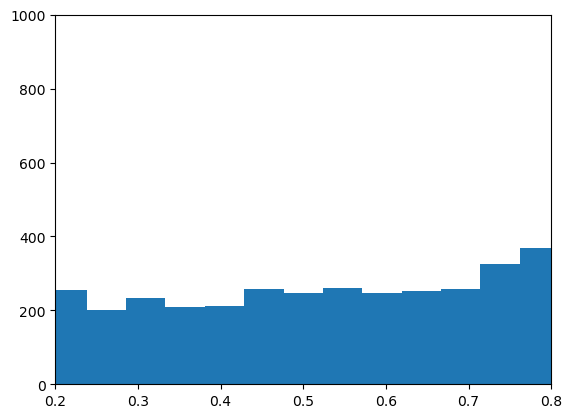

In [80]:
flat = distance_matrix.flatten()
plt.hist(flat, bins=21)
plt.ylim(0, 1000)
plt.xlim(0.2, 0.8)
plt.show()